In [3]:
__author__ = 'tylin'
__version__ = '2.0'
# Interface for accessing the Microsoft COCO dataset.

# Microsoft COCO is a large image dataset designed for object detection,
# segmentation, and caption generation. pycocotools is a Python API that
# assists in loading, parsing and visualizing the annotations in COCO.
# Please visit http://mscoco.org/ for more information on COCO, including
# for the data, paper, and tutorials. The exact format of the annotations
# is also described on the COCO website. For example usage of the pycocotools
# please see pycocotools_demo.ipynb. In addition to this API, please download both
# the COCO images and annotations in order to run the demo.

# An alternative to using the API is to load the annotations directly
# into Python dictionary
# Using the API provides additional utility functions. Note that this API
# supports both *instance* and *caption* annotations. In the case of
# captions not all functions are defined (e.g. categories are undefined).

# The following API functions are defined:
#  COCO       - COCO api class that loads COCO annotation file and prepare data structures.
#  decodeMask - Decode binary mask M encoded via run-length encoding.
#  encodeMask - Encode binary mask M using run-length encoding.
#  getAnnIds  - Get ann ids that satisfy given filter conditions.
#  getCatIds  - Get cat ids that satisfy given filter conditions.
#  getImgIds  - Get img ids that satisfy given filter conditions.
#  loadAnns   - Load anns with the specified ids.
#  loadCats   - Load cats with the specified ids.
#  loadImgs   - Load imgs with the specified ids.
#  annToMask  - Convert segmentation in an annotation to binary mask.
#  showAnns   - Display the specified annotations.
#  loadRes    - Load algorithm results and create API for accessing them.
#  download   - Download COCO images from mscoco.org server.
# Throughout the API "ann"=annotation, "cat"=category, and "img"=image.
# Help on each functions can be accessed by: "help COCO>function".

# See also COCO>decodeMask,
# COCO>encodeMask, COCO>getAnnIds, COCO>getCatIds,
# COCO>getImgIds, COCO>loadAnns, COCO>loadCats,
# COCO>loadImgs, COCO>annToMask, COCO>showAnns

# Microsoft COCO Toolbox.      version 2.0
# Data, paper, and tutorials available at:  http://mscoco.org/
# Code written by Piotr Dollar and Tsung-Yi Lin, 2014.
# Licensed under the Simplified BSD License [see bsd.txt]

import json
import time
import numpy as np
import copy
import itertools
import pdb 
# from . import mask as maskUtils

import os
from collections import defaultdict
import sys
PYTHON_VERSION = sys.version_info[0]
if PYTHON_VERSION == 2:
    from urllib import urlretrieve
elif PYTHON_VERSION == 3:
    from urllib.request import urlretrieve

maskUtils = None 
def _isArrayLike(obj):
    return hasattr(obj, '__iter__') and hasattr(obj, '__len__')


class COCO:
    def __init__(self, annotation_file=None):
        """
        Constructor of Microsoft COCO helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :param image_folder (str): location to the folder that hosts images.
        :return:
        """
        # load dataset
        self.dataset,self.anns,self.cats,self.imgs = dict(),dict(),dict(),dict()
        self.imgToAnns, self.catToImgs = defaultdict(list), defaultdict(list)
        if not annotation_file == None:
            print('loading annotations into memory...')
            tic = time.time()
            with open(annotation_file, 'r') as f:
                dataset = json.load(f)
            assert type(dataset)==dict, 'annotation file format {} not supported'.format(type(dataset))
            print('Done (t={:0.2f}s)'.format(time.time()- tic))
            self.dataset = dataset
            self.createIndex()

    def createIndex(self):
        # create index
        print('creating index...')
        anns, cats, imgs = {}, {}, {}
        imgToAnns,catToImgs = defaultdict(list),defaultdict(list)
        if 'annotations' in self.dataset:
            for ann in self.dataset['annotations']:
                imgToAnns[ann['image_id']].append(ann)
                anns[ann['id']] = ann

        if 'images' in self.dataset:
            for img in self.dataset['images']:
                imgs[img['id']] = img

        if 'categories' in self.dataset:
            for cat in self.dataset['categories']:
                cats[cat['id']] = cat

        if 'annotations' in self.dataset and 'categories' in self.dataset:
            for ann in self.dataset['annotations']:
                # pdb.set_trace()
                catToImgs[ann['category_id'][0]].append(ann['image_id'])

        print('index created!')

        # create class members
        self.anns = anns
        self.imgToAnns = imgToAnns
        self.catToImgs = catToImgs
        self.imgs = imgs
        self.cats = cats

    def info(self):
        """
        Print information about the annotation file.
        :return:
        """
        for key, value in self.dataset['info'].items():
            print('{}: {}'.format(key, value))

    def getAnnIds(self, imgIds=[], catIds=[], areaRng=[], iscrowd=None):
        """
        Get ann ids that satisfy given filter conditions. default skips that filter
        :param imgIds  (int array)     : get anns for given imgs
               catIds  (int array)     : get anns for given cats
               areaRng (float array)   : get anns for given area range (e.g. [0 inf])
               iscrowd (boolean)       : get anns for given crowd label (False or True)
        :return: ids (int array)       : integer array of ann ids
        """
        imgIds = imgIds if _isArrayLike(imgIds) else [imgIds]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(imgIds) == len(catIds) == len(areaRng) == 0:
            anns = self.dataset['annotations']
        else:
            if not len(imgIds) == 0:
                lists = [self.imgToAnns[imgId] for imgId in imgIds if imgId in self.imgToAnns]
                anns = list(itertools.chain.from_iterable(lists))
            else:
                anns = self.dataset['annotations']
            anns = anns if len(catIds)  == 0 else [ann for ann in anns if ann['category_id'][0] in catIds]
            anns = anns if len(areaRng) == 0 else [ann for ann in anns if ann['area'] > areaRng[0] and ann['area'] < areaRng[1]]
        if not iscrowd == None:
            ids = [ann['id'] for ann in anns if ann['iscrowd'] == iscrowd]
        else:
            ids = [ann['id'] for ann in anns]
        return ids

    def getCatIds(self, catNms=[], supNms=[], catIds=[]):
        """
        filtering parameters. default skips that filter.
        :param catNms (str array)  : get cats for given cat names
        :param supNms (str array)  : get cats for given supercategory names
        :param catIds (int array)  : get cats for given cat ids
        :return: ids (int array)   : integer array of cat ids
        """
        catNms = catNms if _isArrayLike(catNms) else [catNms]
        supNms = supNms if _isArrayLike(supNms) else [supNms]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(catNms) == len(supNms) == len(catIds) == 0:
            cats = self.dataset['categories']
        else:
            cats = self.dataset['categories']
            cats = cats if len(catNms) == 0 else [cat for cat in cats if cat['name']          in catNms]
            cats = cats if len(supNms) == 0 else [cat for cat in cats if cat['supercategory'] in supNms]
            cats = cats if len(catIds) == 0 else [cat for cat in cats if cat['id']            in catIds]
        ids = [cat['id'] for cat in cats]
        return ids

    def getImgIds(self, imgIds=[], catIds=[]):
        '''
        Get img ids that satisfy given filter conditions.
        :param imgIds (int array) : get imgs for given ids
        :param catIds (int array) : get imgs with all given cats
        :return: ids (int array)  : integer array of img ids
        '''
        imgIds = imgIds if _isArrayLike(imgIds) else [imgIds]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(imgIds) == len(catIds) == 0:
            ids = self.imgs.keys()
        else:
            ids = set(imgIds)
            for i, catId in enumerate(catIds):
                if i == 0 and len(ids) == 0:
                    ids = set(self.catToImgs[catId])
                else:
                    ids &= set(self.catToImgs[catId])
        return list(ids)

    def loadAnns(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying anns
        :return: anns (object array) : loaded ann objects
        """
        if _isArrayLike(ids):
            return [self.anns[id] for id in ids]
        elif type(ids) == int:
            return [self.anns[ids]]

    def loadCats(self, ids=[]):
        """
        Load cats with the specified ids.
        :param ids (int array)       : integer ids specifying cats
        :return: cats (object array) : loaded cat objects
        """
        if _isArrayLike(ids):
            return [self.cats[id] for id in ids]
        elif type(ids) == int:
            return [self.cats[ids]]

    def loadImgs(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying img
        :return: imgs (object array) : loaded img objects
        """
        if _isArrayLike(ids):
            return [self.imgs[id] for id in ids]
        elif type(ids) == int:
            return [self.imgs[ids]]

    def showAnns(self, anns, draw_bbox=False):
        """
        Display the specified annotations.
        :param anns (array of object): annotations to display
        :return: None
        """
        if len(anns) == 0:
            return 0
        if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
            datasetType = 'instances'
        elif 'caption' in anns[0]:
            datasetType = 'captions'
        else:
            raise Exception('datasetType not supported')
        if datasetType == 'instances':
            import matplotlib.pyplot as plt
            from matplotlib.collections import PatchCollection
            from matplotlib.patches import Polygon

            ax = plt.gca()
            ax.set_autoscale_on(False)
            polygons = []
            color = []
            for ann in anns:
                c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
                if 'segmentation' in ann:
                    if type(ann['segmentation']) == list:
                        # polygon
                        for seg in ann['segmentation']:
                            poly = np.array(seg).reshape((int(len(seg)/2), 2))
                            polygons.append(Polygon(poly))
                            color.append(c)
                    else:
                        # mask
                        t = self.imgs[ann['image_id']]
                        if type(ann['segmentation']['counts']) == list:
                            rle = maskUtils.frPyObjects([ann['segmentation']], t['height'], t['width'])
                        else:
                            rle = [ann['segmentation']]
                        m = maskUtils.decode(rle)
                        img = np.ones( (m.shape[0], m.shape[1], 3) )
                        if ann['iscrowd'] == 1:
                            color_mask = np.array([2.0,166.0,101.0])/255
                        if ann['iscrowd'] == 0:
                            color_mask = np.random.random((1, 3)).tolist()[0]
                        for i in range(3):
                            img[:,:,i] = color_mask[i]
                        ax.imshow(np.dstack( (img, m*0.5) ))
                if 'keypoints' in ann and type(ann['keypoints']) == list:
                    # turn skeleton into zero-based index
                    sks = np.array(self.loadCats(ann['category_id'][0])[0]['skeleton'])-1
                    kp = np.array(ann['keypoints'])
                    x = kp[0::3]
                    y = kp[1::3]
                    v = kp[2::3]
                    for sk in sks:
                        if np.all(v[sk]>0):
                            plt.plot(x[sk],y[sk], linewidth=3, color=c)
                    plt.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
                    plt.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

                if draw_bbox:
                    [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
                    poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
                    np_poly = np.array(poly).reshape((4,2))
                    polygons.append(Polygon(np_poly))
                    color.append(c)

            p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        elif datasetType == 'captions':
            for ann in anns:
                print(ann['caption'])

    def loadRes(self, resFile):
        """
        Load result file and return a result api object.
        :param   resFile (str)     : file name of result file
        :return: res (obj)         : result api object
        """
        res = COCO()
        res.dataset['images'] = [img for img in self.dataset['images']]

        print('Loading and preparing results...')
        tic = time.time()
        if type(resFile) == str or (PYTHON_VERSION == 2 and type(resFile) == unicode):
            with open(resFile) as f:
                anns = json.load(f)
        elif type(resFile) == np.ndarray:
            anns = self.loadNumpyAnnotations(resFile)
        else:
            anns = resFile
        assert type(anns) == list, 'results in not an array of objects'
        annsImgIds = [ann['image_id'] for ann in anns]
        assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
               'Results do not correspond to current coco set'
        if 'caption' in anns[0]:
            imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
            res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
            for id, ann in enumerate(anns):
                ann['id'] = id+1
        elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                bb = ann['bbox']
                x1, x2, y1, y2 = [bb[0], bb[0]+bb[2], bb[1], bb[1]+bb[3]]
                if not 'segmentation' in ann:
                    ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
                ann['area'] = bb[2]*bb[3]
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'segmentation' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                # now only support compressed RLE format as segmentation results
                ann['area'] = maskUtils.area(ann['segmentation'])
                if not 'bbox' in ann:
                    ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'keypoints' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                s = ann['keypoints']
                x = s[0::3]
                y = s[1::3]
                x0,x1,y0,y1 = np.min(x), np.max(x), np.min(y), np.max(y)
                ann['area'] = (x1-x0)*(y1-y0)
                ann['id'] = id + 1
                ann['bbox'] = [x0,y0,x1-x0,y1-y0]
        print('DONE (t={:0.2f}s)'.format(time.time()- tic))

        res.dataset['annotations'] = anns
        res.createIndex()
        return res

    def download(self, tarDir = None, imgIds = [] ):
        '''
        Download COCO images from mscoco.org server.
        :param tarDir (str): COCO results directory name
               imgIds (list): images to be downloaded
        :return:
        '''
        if tarDir is None:
            print('Please specify target directory')
            return -1
        if len(imgIds) == 0:
            imgs = self.imgs.values()
        else:
            imgs = self.loadImgs(imgIds)
        N = len(imgs)
        if not os.path.exists(tarDir):
            os.makedirs(tarDir)
        for i, img in enumerate(imgs):
            tic = time.time()
            fname = os.path.join(tarDir, img['file_name'])
            if not os.path.exists(fname):
                urlretrieve(img['coco_url'], fname)
            print('downloaded {}/{} images (t={:0.1f}s)'.format(i, N, time.time()- tic))

    def loadNumpyAnnotations(self, data):
        """
        Convert result data from a numpy array [Nx7] where each row contains {imageID,x1,y1,w,h,score,class}
        :param  data (numpy.ndarray)
        :return: annotations (python nested list)
        """
        print('Converting ndarray to lists...')
        assert(type(data) == np.ndarray)
        print(data.shape)
        assert(data.shape[1] == 7)
        N = data.shape[0]
        ann = []
        for i in range(N):
            if i % 1000000 == 0:
                print('{}/{}'.format(i,N))
            ann += [{
                'image_id'  : int(data[i, 0]),
                'bbox'  : [ data[i, 1], data[i, 2], data[i, 3], data[i, 4] ],
                'score' : data[i, 5],
                'category_id': int(data[i, 6]),
                }]
        return ann

    def annToRLE(self, ann):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        t = self.imgs[ann['image_id']]
        h, w = t['height'], t['width']
        segm = ann['segmentation']
        if type(segm) == list:
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, h, w)
            rle = maskUtils.merge(rles)
        elif type(segm['counts']) == list:
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, h, w)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann)
        m = maskUtils.decode(rle)
        return m



In [5]:
from rich import print 
annFile='/home/yunzhi/yunzhi/datasets/participant_property/labels/train/train_coco.json'
coco=COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))


# imgIds = coco.getImgIds(imgIds = [1,2,3,4])
# print(imgIds)


loading annotations into memory...

Done (t=0.02s)

creating index...

index created!

COCO categories: 
car suv small truck big truck bus special tricycle motorcycle_electric vehicle bicycle pedestrian others

catIds: [1, 2, 5]

imgIds: [100, 101, 102, 41, 45]

In [13]:
catIds = coco.getCatIds(catNms=['pedestrian'])
print(f"catIds: {catIds}")
imgIds = coco.getImgIds(catIds=catIds)
print(f"imgIds: {imgIds}")

catIds: [10]

imgIds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53,
54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 105, 106, 108, 109, 110, 111, 112, 
115, 116, 118, 119, 120, 121, 122, 123]

[{'id': 1, 'name': 'car', 'count': 1045},
 {'id': 2, 'name': 'suv', 'count': 564},
 {'id': 3, 'name': 'small truck', 'count': 191},
 {'id': 4, 'name': 'big truck', 'count': 14},
 {'id': 5, 'name': 'bus', 'count': 18},
 {'id': 6, 'name': 'special', 'count': 395},
 {'id': 7, 'name': 'tricycle', 'count': 42},
 {'id': 8, 'name': 'motorcycle_electric vehicle', 'count': 122},
 {'id': 9, 'name': 'bicycle', 'count': 32},
 {'id': 10, 'name': 'pedestrian', 'count': 629},
 {'id': 11, 'name': 'others', 'count': 548}]

In [7]:
img = coco.loadImgs(100)
img[0]['file_name']

[{'file_name': '58500d5bdffd2a600197b33402dc78e7.jpg',
  'height': 1080,
  'width': 1920,
  'id': 100}]

In [17]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

TypeError: list indices must be integers or slices, not str

In [16]:
img_dir = '/home/yunzhi/yunzhi/datasets/participant_property/images'
img_dir.join(img[0]['file_name'])

'5/home/yunzhi/yunzhi/datasets/participant_property/images8/home/yunzhi/yunzhi/datasets/participant_property/images5/home/yunzhi/yunzhi/datasets/participant_property/images0/home/yunzhi/yunzhi/datasets/participant_property/images0/home/yunzhi/yunzhi/datasets/participant_property/imagesd/home/yunzhi/yunzhi/datasets/participant_property/images5/home/yunzhi/yunzhi/datasets/participant_property/imagesb/home/yunzhi/yunzhi/datasets/participant_property/imagesd/home/yunzhi/yunzhi/datasets/participant_property/imagesf/home/yunzhi/yunzhi/datasets/participant_property/imagesf/home/yunzhi/yunzhi/datasets/participant_property/imagesd/home/yunzhi/yunzhi/datasets/participant_property/images2/home/yunzhi/yunzhi/datasets/participant_property/imagesa/home/yunzhi/yunzhi/datasets/participant_property/images6/home/yunzhi/yunzhi/datasets/participant_property/images0/home/yunzhi/yunzhi/datasets/participant_property/images0/home/yunzhi/yunzhi/datasets/participant_property/images1/home/yunzhi/yunzhi/datasets/

In [28]:
import json 
import os 
from PIL import Image
import os.path as osp 
coco = json.load(open('/home/yunzhi/yunzhi/datasets/participant_property/labels/train/train_coco.json', 'r'))

In [29]:
for anno in coco['annotations']:
    img_id = anno['image_id']
    category_id = anno['category_id']
    bbox = anno['bbox']
    img_path = osp.join(img_dir, coco['images'][img_id]['file_name'])
    img = Image.open(img_path)
    break 

In [44]:
img_id

1

In [36]:
coco['categories']

[{'id': 1, 'name': 'car', 'count': 1045},
 {'id': 2, 'name': 'suv', 'count': 564},
 {'id': 3, 'name': 'small truck', 'count': 191},
 {'id': 4, 'name': 'big truck', 'count': 14},
 {'id': 5, 'name': 'bus', 'count': 18},
 {'id': 6, 'name': 'special', 'count': 395},
 {'id': 7, 'name': 'tricycle', 'count': 42},
 {'id': 8, 'name': 'motorcycle_electric vehicle', 'count': 122},
 {'id': 9, 'name': 'bicycle', 'count': 32},
 {'id': 10, 'name': 'pedestrian', 'count': 629},
 {'id': 11, 'name': 'others', 'count': 548}]

In [42]:
from PIL import ImageDraw
def visualize_bbox(image, bboxes):
    # 打开图像
    # image = Image.open(image_path)
    
    # 创建绘图对象
    draw = ImageDraw.Draw(image)
    
    # 绘制每个边界框
    for bbox in bboxes:
        x, y, w, h = bbox['bbox']
        label = bbox['category_id']
        
        # 设置框的颜色和宽度
        color = (255, 0, 0)  # 红色
        thickness = 2
        
        # 绘制矩形框
        draw.rectangle([(x, y), (x+w, y+h)], outline=color, width=thickness)
        
        # 绘制标签
        draw.text((x, y-10), str(label), fill=color)
    
# 示例用法
# image_path = 'path_to_your_image.jpg'  # 替换为实际图像路径
bboxes = [
    {'bbox': bbox, 'category_id': coco['categories'][category_id[0]-1]},
    # {'bbox': [300, 150, 70, 90], 'category_id': 'car'},
    # 添加更多的边界框
]

visualize_bbox(img, bboxes)

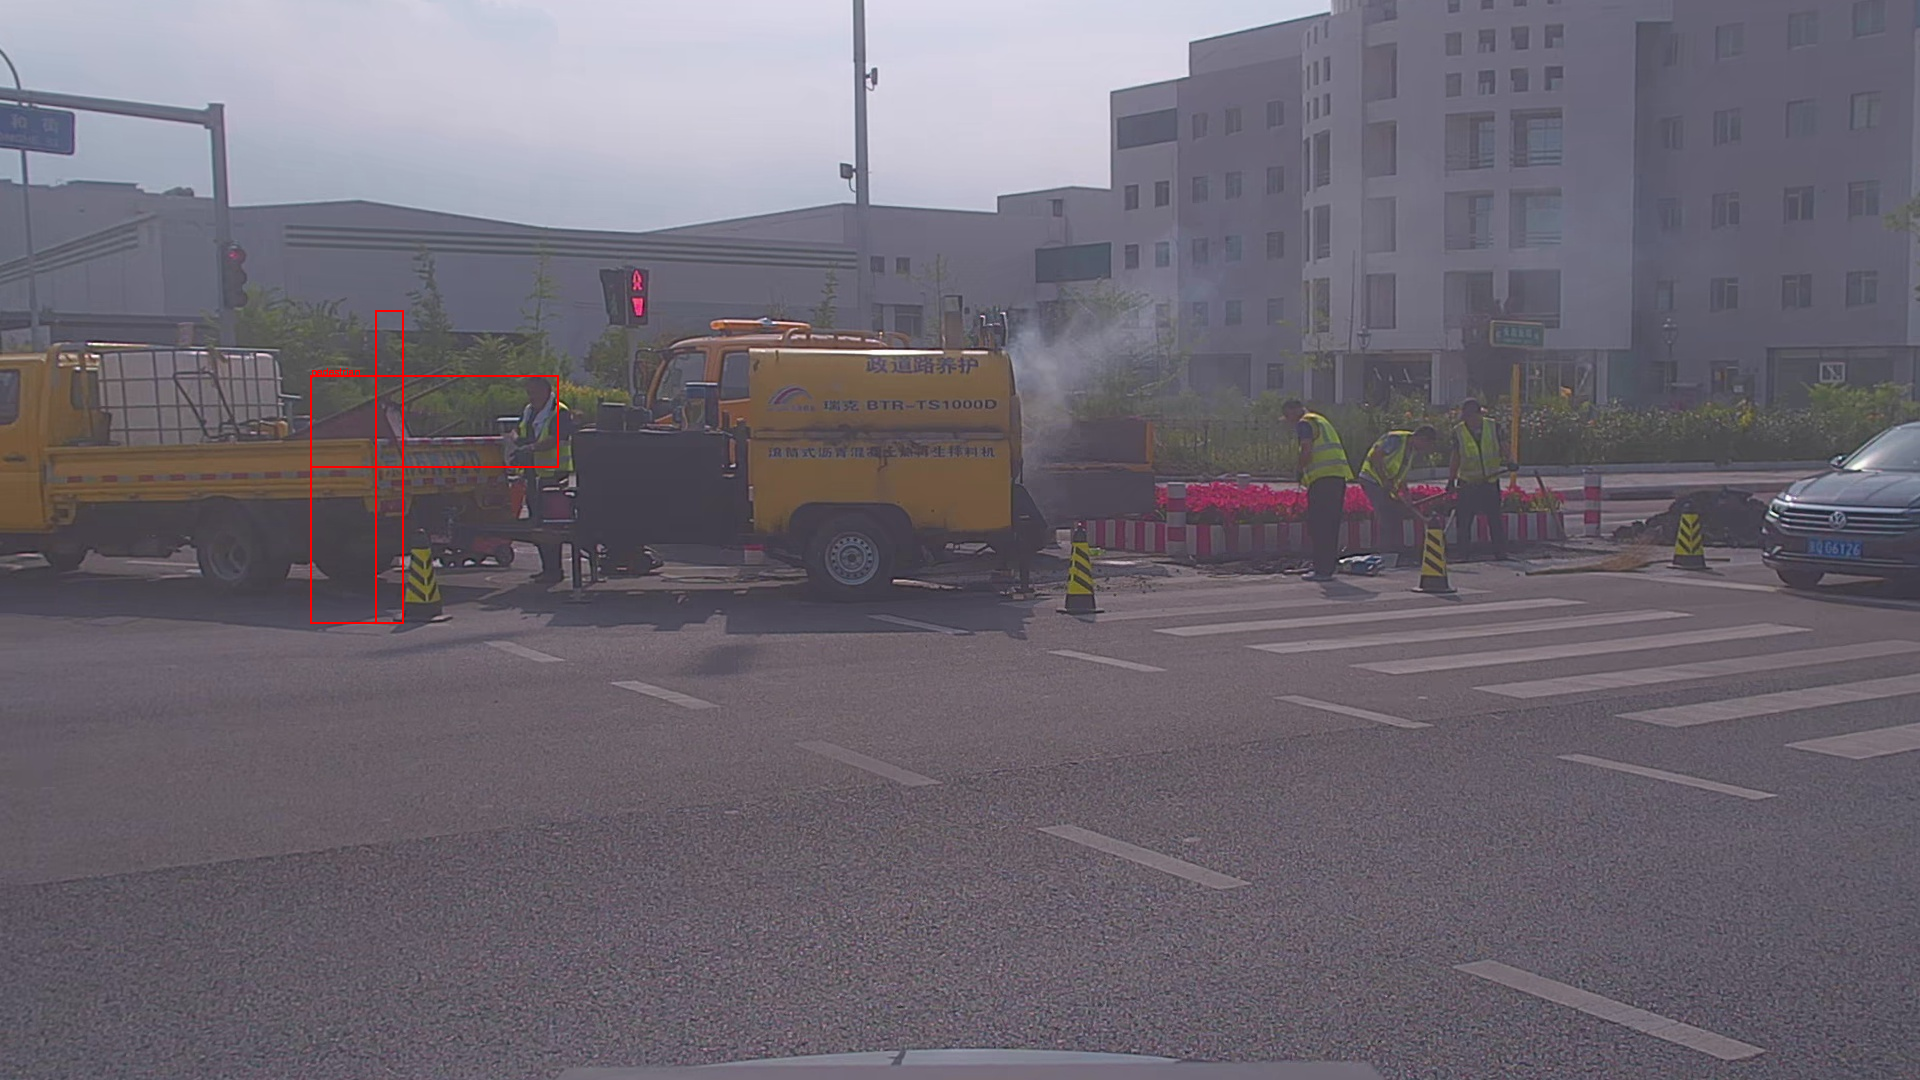

In [43]:
img

In [32]:
bbox, category_id

([310.6740597222, 375.6126834947, 92.34234234230001, 247.74774774769998],
 [10, 2])

In [22]:
coco['images']

[{'file_name': '7917571c4527aeb66554da074c01ce42.jpg',
  'height': 1080,
  'width': 1920,
  'id': 1},
 {'file_name': '30b3816428b7e78dab1e492cff7cdfce.jpg',
  'height': 1080,
  'width': 1920,
  'id': 2},
 {'file_name': 'ee48bb4b63533ba847b0895cfa1941d1.jpg',
  'height': 1080,
  'width': 1920,
  'id': 3},
 {'file_name': 'd01850dd0dd0bd7d1da92b2d7f6009e4.jpg',
  'height': 1080,
  'width': 1920,
  'id': 4},
 {'file_name': 'da60febf325bca052c854fbc1540afb1.jpg',
  'height': 1080,
  'width': 1920,
  'id': 5},
 {'file_name': '9a0160bbbc4d26645ee28bd2a49fa09c.jpg',
  'height': 1080,
  'width': 1920,
  'id': 6},
 {'file_name': '5c14c267d5873ce9ec095c8a016a62cc.jpg',
  'height': 1080,
  'width': 1920,
  'id': 7},
 {'file_name': 'eaa342456ee6bc9468c0c7d6e2037b90.jpg',
  'height': 1080,
  'width': 1920,
  'id': 8},
 {'file_name': '1ae9d17703d8dd2817ad765a11e6bb85.jpg',
  'height': 1080,
  'width': 1920,
  'id': 9},
 {'file_name': '47a56551ac69e56e08c41dab4fa74057.jpg',
  'height': 1080,
  'width'

In [20]:
coco['annotations']

[{'id': 1664,
  'image_id': 1,
  'category_id': [10, 2],
  'scalabel_id': '1663',
  'iscrowd': 0,
  'ignore': 0,
  'bbox': [310.6740597222,
   375.6126834947,
   92.34234234230001,
   247.74774774769998],
  'area': 22877.607337051897},
 {'id': 1665,
  'image_id': 1,
  'category_id': [10, 1],
  'scalabel_id': '1664',
  'iscrowd': 0,
  'ignore': 0,
  'bbox': [1189.0524381006, 400.3874582695, 82.20720720719987, 208.3333333333],
  'area': 17126.501501497234},
 {'id': 1666,
  'image_id': 1,
  'category_id': [10, 1],
  'scalabel_id': '1665',
  'iscrowd': 0,
  'ignore': 0,
  'bbox': [1275.7641498123,
   428.5406114226,
   83.33333333330006,
   167.79279279280001],
  'area': 13982.73273272775},
 {'id': 1667,
  'image_id': 1,
  'category_id': [10, 2],
  'scalabel_id': '1666',
  'iscrowd': 0,
  'ignore': 0,
  'bbox': [1363.6019876501,
   400.3874582695,
   81.08108108109991,
   185.81081081079998],
  'area': 15065.741417095389},
 {'id': 1668,
  'image_id': 1,
  'category_id': [7, 1],
  'scalabel

In [56]:
from glob import glob 
from torch.utils.data import Dataset
class MyData(Dataset):
    def __init__(self, data_root) -> None:
        super().__init__()
        self.data_root = data_root 
        for data_root, categories, _ in os.walk(data_root):
            self.categories = categories
            break 
        self.data_infos = []
        for cat in self.categories:
            img_paths = glob(osp.join(self.data_root, cat, '*.jpg'))
            for path in img_paths:
                data_info = dict(
                    path=path,
                    label=cat 
                )
                self.data_infos.append(data_info)
        # self.data_infos
    def __len__(self):
        return len(self.data_infos)
    
    def __getitem__(self, index):
        data_info = self.data_infos[index].copy()
        img = Image.open(data_info['path'])
        data_info['img'] = img
        return data_info

In [57]:
dataset = MyData(data_root='data')

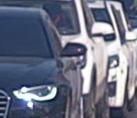

In [69]:
dataset[100]['img']

In [70]:
dataset[100]['label']

'car'